# Your first deep neural network

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Flatten, Dense, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.datasets import cifar10

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # 避免notebook 执行时退出

Using TensorFlow backend.
/Users/chenwang/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chenwang/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chenwang/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chen

# data

CIFAR-10 dataset: 一共包含10类不同的物体的图片，label 分别是0-9.
- x_train: [50000, 32, 32, 3]  50000 个样本，每个样本是32*32个像素，彩色图片3通道
- x_test: [10000, 32, 32, 3]  10000 个样本
- y_train: [50000, 1]  
- y_test: [10000, 1] 

<img src="figures/cifar-10.png" alt="drawing" width="600"/>


In [2]:
NUM_CLASSES = 10

In [16]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [17]:
print('x_train.shape: ', x_train.shape)
print('x_test.shape: ', x_test.shape)

print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (50000, 32, 32, 3)
x_test.shape:  (10000, 32, 32, 3)
y_train.shape:  (50000, 1)
y_test.shape:  (10000, 1)


In [18]:
x_train[54, 12, 13, 1] 

94

#### 简单预处理
1. 使X 的值在0-1 之间
2. 对y 做one-hot encoding

In [19]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [22]:
print('x_train.shape: ', x_train.shape)
print('x_test.shape: ', x_test.shape)

print('y_train.shape: ', y_train.shape)  # y 的dimension 由原来的1增加到10
print('y_test.shape: ', y_test.shape)

x_train.shape:  (50000, 32, 32, 3)
x_test.shape:  (10000, 32, 32, 3)
y_train.shape:  (50000, 10)
y_test.shape:  (10000, 10)


In [21]:
x_train[54, 12, 13, 1] 

0.36862746

# architecture

<img src="figures/network_structure.png" alt="drawing" width="600"/>


一般有两种方法定义model:
- sequential model: 顺序叠加
- Functional API: 和上面相比，多了branching 功能，例如一个layer 可能输出多个不同的层。The Functional API will give you complete freedom over the design of your deep neural network.

### 1. sequential model

In [23]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

seq_model = Sequential([
    Dense(200, activation = 'relu', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(150, activation = 'relu'),
    Dense(10, activation = 'softmax'),
])

In [24]:
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32, 32, 200)       800       
_________________________________________________________________
flatten_2 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               30720150  
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1510      
Total params: 30,722,460
Trainable params: 30,722,460
Non-trainable params: 0
_________________________________________________________________


### 2. Functional API

我们使用了三种不同的层：
- input：输入的数据vector 长度，这里我们不指定batch size（因为这个和参数个数毫无关系）
- flatten：把一个tensor 拉成一个vector。在这个例子里，vector 的长度是：3,072 (= 32 × 32 × 3).
- dense：需要一个vector 作为输入。

In [6]:
input_layer = Input((32,32,3))

x = Flatten()(input_layer)

x = Dense(200, activation = 'relu')(x)
"""
也可以分开看作两层来定义，因为实际上是做了两个操作。上述写法等同于：
x = Dense(units=200)(x)
x = Activation('relu')(x)
"""

x = Dense(150, activation = 'relu')(x)

output_layer = Dense(NUM_CLASSES, activation = 'softmax')(x)

# In Keras a model is defined by the input and output layers.
model = Model(input_layer, output_layer)

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               614600    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1510      
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


通过模型summary，我们可以检验input layer 和x的维度对应（忽略batch 个数，这里用None 代替，因为我么定义模型的时候并不知道有多少个observations会被用来训练），而最后一个dense layer 与y的维度对应。

# Compile and traing the model

我们通常需要使用一个optimizer 和一个loss function 来compile model.

#### Loss Function
- regression: mean squared error
- binary classification / multi-label classification: binary cross-entropy
- multiclass classification: categorical cross-entropy

#### Optimizer
用来update the weights in the neural network based on the gradient of the loss function.

一般我们只需要调整optimizer 的learning rate.

#### Metrics
在训练过程中需要report 的matrics

#### Metrics 和Loss Function 的区别？


In [8]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

- shuffle = True：每个batch 都会随机选择训练样本，without replacement；
- batch size 越大, 梯度的计算越稳定, 训练过程也越慢。一般设置在32 - 256之间；

首先，所有的weights 会初始化成很小的随机值。

一些训练的最佳实践：
- Don’t Decay the Learning Rate, Increase the Batch Size


In [9]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True)


Epoch 1/10
50000/50000 [==============================] - 39s 782us/step - loss: 1.8505 - accuracy: 0.3348
Epoch 2/10
50000/50000 [==============================] - 40s 804us/step - loss: 1.6675 - accuracy: 0.4039
Epoch 3/10
50000/50000 [==============================] - 39s 783us/step - loss: 1.5855 - accuracy: 0.4351
Epoch 4/10
50000/50000 [==============================] - 39s 775us/step - loss: 1.5288 - accuracy: 0.4545
Epoch 5/10
50000/50000 [==============================] - 39s 774us/step - loss: 1.4928 - accuracy: 0.4663
Epoch 6/10
50000/50000 [==============================] - 43s 853us/step - loss: 1.4582 - accuracy: 0.4796
Epoch 7/10
50000/50000 [==============================] - 39s 779us/step - loss: 1.4344 - accuracy: 0.4866
Epoch 8/10
50000/50000 [==============================] - 39s 786us/step - loss: 1.4074 - accuracy: 0.4987
Epoch 9/10
50000/50000 [==============================] - 39s 773us/step - loss: 1.3868 - accuracy: 0.5063
Epoch 10/10
50000/50000 [===========

# analysis

通过训练10轮，我们看出准确率在51%左右。下面我们看在测试机伤的表现。
从下面的结果可以看出，在测试集上，loss 是1.438 （训练集是1.365），准确率是0.49（训练集是0.51）。如果是随便猜，因为有10个class，所以准确率应该在10%左右。

In [10]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 120us/step


[1.4382466680526733, 0.49050000309944153]

下面，我们打印一些图片来看。

- preds is an array of shape [10000, 10]
- 把预测结果从one-hot转换回一个数的表示（使用argmax），preds_single 是一个[10000, 1] 的矩阵
- 把标签从one-hot 转换回一个数的表示，actual_single 是一个[10000, 1] 的矩阵

In [11]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

In [25]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

print(indices)

[ 238 4187 9972 8701  573 7829 7811 7492 9112 4100]


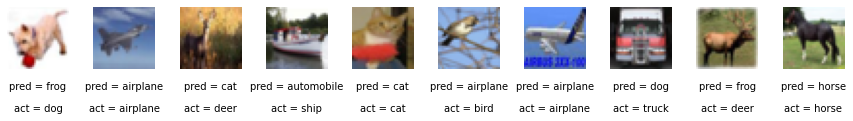

In [26]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)


这个网络表现不好的一个原因可能在于，没有扑捉到空间信息，后面我们可以看到通过添加convolution layer 来改进网络性能。